Dataset

In [22]:
import pandas as pd
import numpy as np

ufs = ['SP', 'RJ', 'MG', 'ES', 'RS', 'PR', 'SC', 'BA', 'GO', 'PE']
modal = ['Rodovi√°rio', 'A√©reo', 'Ferrovi√°rio']
tipo_carga = ['Industrial', 'Perec√≠vel', 'Inflam√°vel', 'Fr√°gil', 'Comum']

n = 1000  # Quantidade de linhas (fretes simulados)

df = pd.DataFrame({
    'origem_uf': np.random.choice(ufs, n),
    'destino_uf': np.random.choice(ufs, n),
    'distancia_km': np.random.randint(50, 3000, n),
    'peso_kg': np.random.uniform(100, 30000, n).round(2),
    'tipo_carga': np.random.choice(tipo_carga, n),
    'modal': np.random.choice(modal, n),
    'prazo_dias': np.random.randint(1, 15, n)
})

def calcular_frete(row):
    base = 3.5 * row['distancia_km'] + 0.02 * row['peso_kg']
    
    if row['modal'] == 'A√©reo':
        base *= 1.5
    elif row['modal'] == 'Ferrovi√°rio':
        base *= 0.9

    if row['tipo_carga'] == 'Perec√≠vel':
        base *= 1.2
    elif row['tipo_carga'] == 'Inflam√°vel':
        base *= 1.3
    elif row['tipo_carga'] == 'Fr√°gil':
        base *= 1.15

    if row['prazo_dias'] <= 3:
        base *= 1.4  # frete expresso

    return round(base + np.random.normal(0, 300), 2)

df['frete_final_r$'] = df.apply(calcular_frete, axis=1)  # Cria nova coluna

df.to_csv('fretes_simulados.csv', index=False)  # Salva o arquivo


EDA

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo dos gr√°ficos
sns.set(style='whitegrid', palette='pastel')
plt.rcParams['figure.figsize'] = (10, 6)

# Carregar o CSV
df = pd.read_csv('fretes_simulados.csv')

# Ver as 5 primeiras linhas
print(df.head())

# Ver estrutura b√°sica
print("\nINFO:")
print(df.info())

# Estat√≠sticas descritivas
print("\nDESCRIBE:")
print(df.describe())

  origem_uf destino_uf  distancia_km   peso_kg  tipo_carga        modal  \
0        BA         PE          2173   1650.94      Fr√°gil  Ferrovi√°rio   
1        RJ         MG           914  26192.43   Perec√≠vel   Rodovi√°rio   
2        BA         PR            56   2382.06       Comum  Ferrovi√°rio   
3        MG         GO           557  21788.82       Comum  Ferrovi√°rio   
4        GO         MG           900  11132.73  Inflam√°vel        A√©reo   

   prazo_dias  frete_final_r$  
0           5         7763.96  
1           2         6361.64  
2           8          520.65  
3          10         2480.28  
4           5         6592.30  

INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   origem_uf       1000 non-null   object 
 1   destino_uf      1000 non-null   object 
 2   distancia_km    1000 non-null   int64  
 3   peso_kg

Visualiza√ß√µes

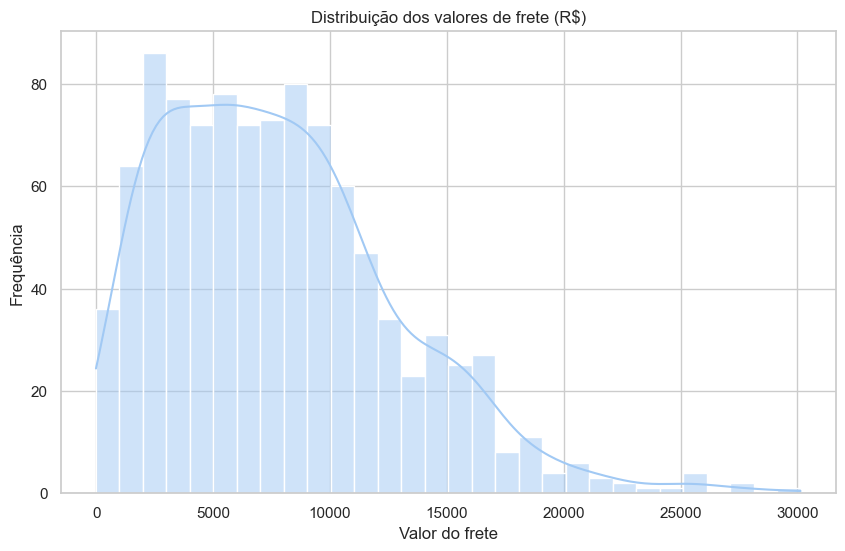

In [24]:
sns.histplot(df['frete_final_r$'], kde=True, bins=30)
plt.title('Distribui√ß√£o dos valores de frete (R$)')
plt.xlabel('Valor do frete')
plt.ylabel('Frequ√™ncia')
plt.show()

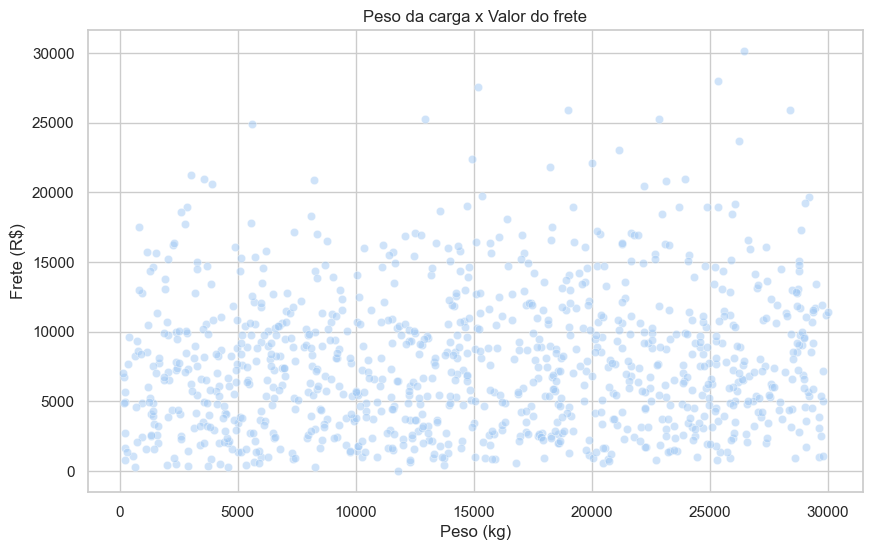

In [25]:
sns.scatterplot(x='peso_kg', y='frete_final_r$', data=df, alpha=0.5)
plt.title('Peso da carga x Valor do frete')
plt.xlabel('Peso (kg)')
plt.ylabel('Frete (R$)')
plt.show()

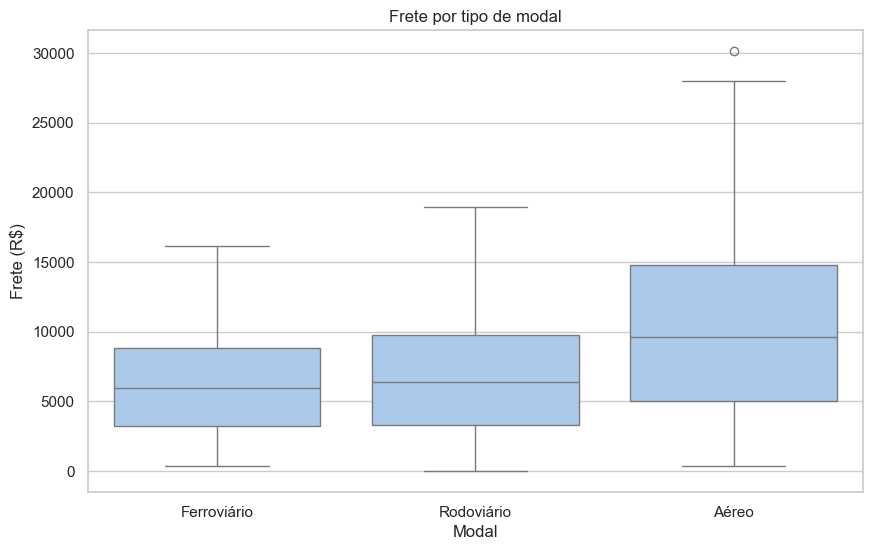

In [26]:
sns.boxplot(x='modal', y='frete_final_r$', data=df)
plt.title('Frete por tipo de modal')
plt.xlabel('Modal')
plt.ylabel('Frete (R$)')
plt.show()

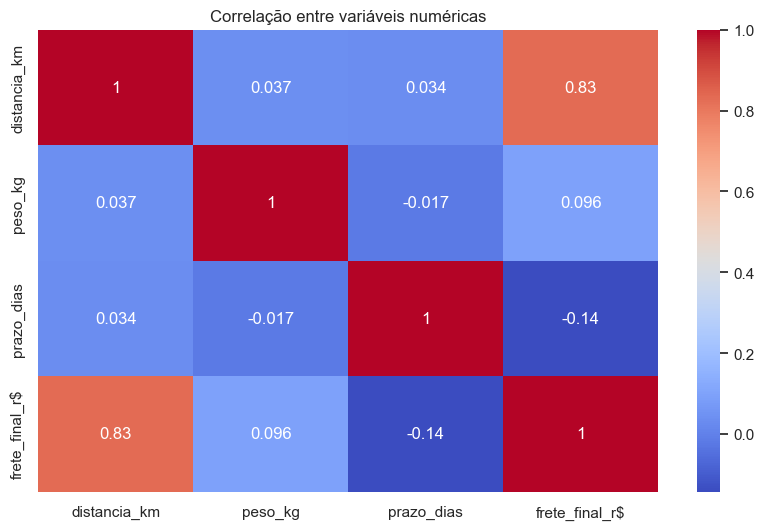

In [27]:
corr = df.corr(numeric_only=True)

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correla√ß√£o entre vari√°veis num√©ricas')
plt.show()

Pre-processamento

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

df = pd.read_csv('fretes_simulados.csv')

# y √© o que queremos prever (target)
y = df['frete_final_r$']

# X s√£o as vari√°veis de entrada (features)
X = df.drop('frete_final_r$', axis=1)

# Categ√≥ricas
cat_cols = ['origem_uf', 'destino_uf', 'modal', 'tipo_carga']

# Num√©ricas
num_cols = ['distancia_km', 'peso_kg', 'prazo_dias']

# OneHot para colunas categ√≥ricas
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Escalar as num√©ricas
numerical_transformer = StandardScaler()

# Compor o pr√©-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Treinar o modelo (Regressao Linear)

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Criar o pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessador', preprocessor),            # Etapa 1: transformar os dados
    ('modelo', LinearRegression())               # Etapa 2: treinar modelo
])

# 2. Treinar o modelo nos dados de treino
model_pipeline.fit(X_train, y_train)

# 3. Fazer previs√µes nos dados de teste
y_pred = model_pipeline.predict(X_test)

# 4. Avaliar o desempenho
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R¬≤: {r2:.2f}')

MAE: 1221.83
RMSE: 1767.34
R¬≤: 0.88


Visualizar erros

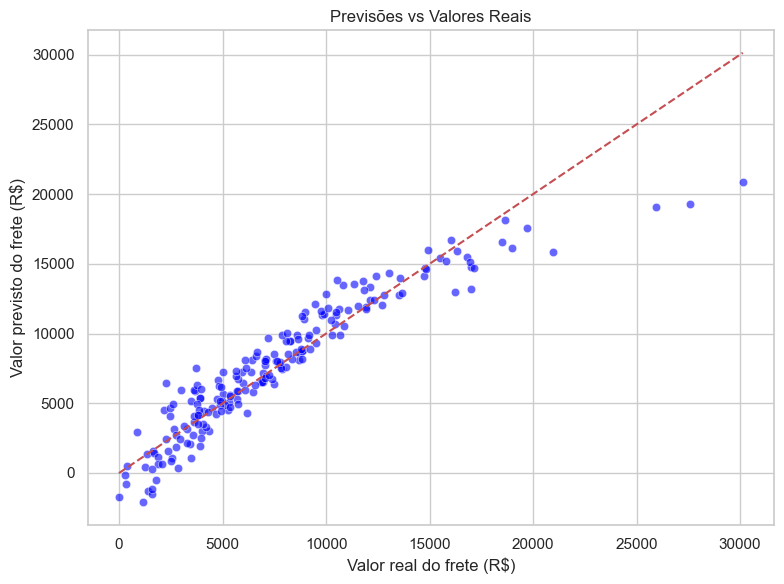

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo visual
sns.set(style='whitegrid')

# Plotando previs√µes vs reais
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # Linha ideal (acertos perfeitos)
plt.xlabel('Valor real do frete (R$)')
plt.ylabel('Valor previsto do frete (R$)')
plt.title('Previs√µes vs Valores Reais')
plt.tight_layout()
plt.show()

Treinar modelo (Random Forest)

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Novo pipeline com Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessador', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Treinar o modelo
rf_pipeline.fit(X_train, y_train)

# Fazer previs√µes
y_pred_rf = rf_pipeline.predict(X_test)

# Avaliar
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE: {mae_rf:.2f}")
print(f"Random Forest - RMSE: {rmse_rf:.2f}")
print(f"Random Forest - R¬≤: {r2_rf:.2f}")

Random Forest - MAE: 659.81
Random Forest - RMSE: 900.11
Random Forest - R¬≤: 0.97


Importancia das Features

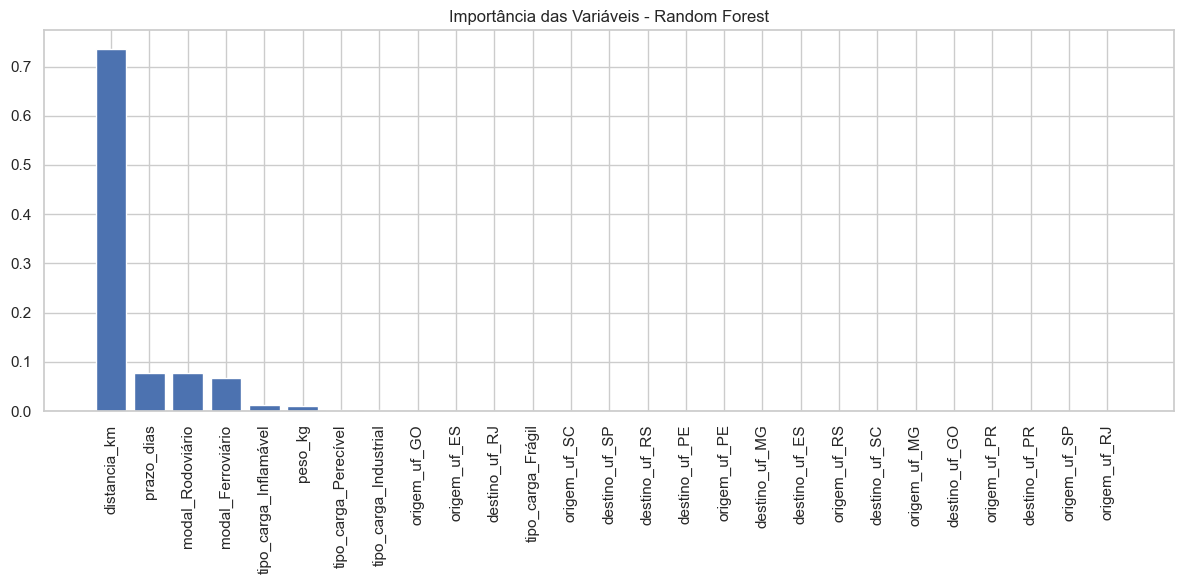

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Acessar o modelo Random Forest treinado de dentro do pipeline
rf_model = rf_pipeline.named_steps['regressor']

# Pegar o nome das features ap√≥s o processamento
# Isso inclui os nomes gerados pelo OneHotEncoder
feature_names = (
    rf_pipeline.named_steps['preprocessador']
    .transformers_[0][2] +  # num√©ricas
    list(
        rf_pipeline.named_steps['preprocessador']
        .transformers_[1][1]
        .get_feature_names_out(['origem_uf', 'destino_uf', 'modal', 'tipo_carga'])
    )
)

# Import√¢ncia das features
importances = rf_model.feature_importances_

# Organizar
indices = np.argsort(importances)[::-1]
sorted_features = np.array(feature_names)[indices]
sorted_importances = importances[indices]

# Plotar
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), sorted_importances, align='center')
plt.xticks(range(len(importances)), sorted_features, rotation=90)
plt.title('Import√¢ncia das Vari√°veis - Random Forest')
plt.tight_layout()
plt.show()

GridSearchCV

In [33]:
from sklearn.model_selection import GridSearchCV

# Pipeline de novo com nome
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Par√¢metros pra tunar
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['sqrt', 'log2']
}

# Grid Search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

# Treinar
grid_search.fit(X_train, y_train)

# Melhor resultado
print("Melhores par√¢metros:", grid_search.best_params_)
print("Melhor score R¬≤:", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Melhores par√¢metros: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Melhor score R¬≤: 0.882119796471051


Avaliar o modelo com os melhores parametros

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Usar o melhor modelo
best_model = grid_search.best_estimator_

# Previs√µes no conjunto de teste
y_pred = best_model.predict(X_test)

# Avalia√ß√£o
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Tunado - MAE: {mae:.2f}")
print(f"Random Forest Tunado - RMSE: {rmse:.2f}")
print(f"Random Forest Tunado - R¬≤: {r2:.2f}")

Random Forest Tunado - MAE: 1048.29
Random Forest Tunado - RMSE: 1610.99
Random Forest Tunado - R¬≤: 0.90


Importancia das Features (Tunado)

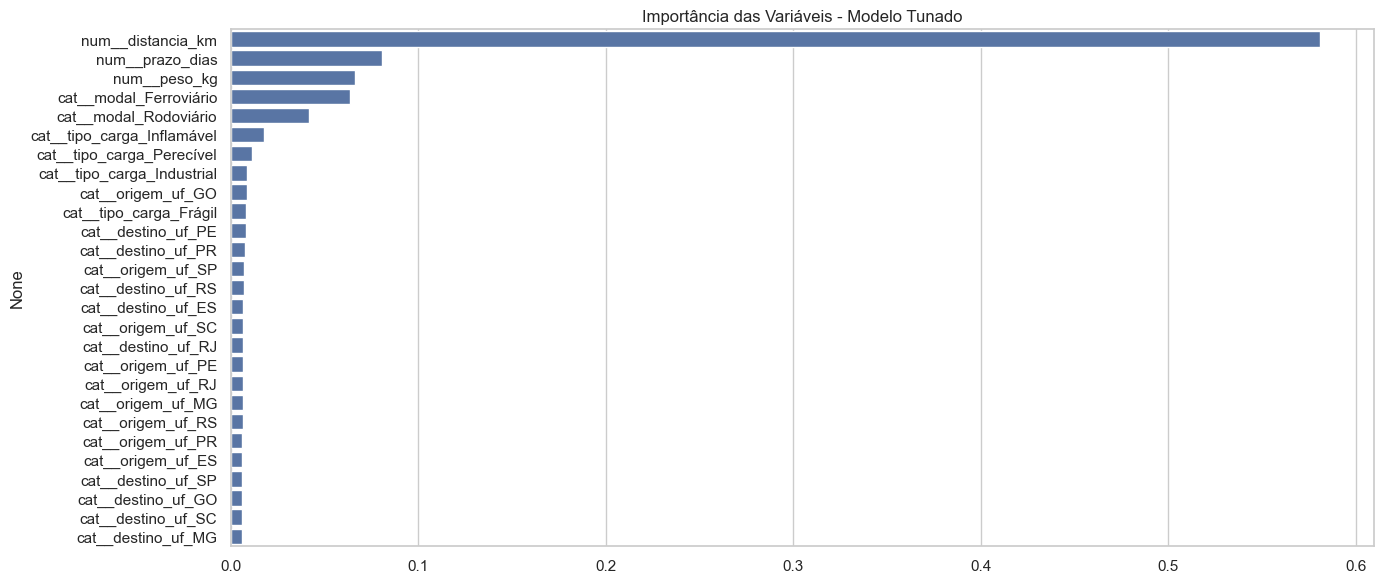

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pegar o regressor final do pipeline
rf_model = best_model.named_steps['regressor']
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Import√¢ncia
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Import√¢ncia das Vari√°veis - Modelo Tunado")
plt.tight_layout()
plt.show()

Salvar modelo

In [36]:
import joblib

joblib.dump(best_model, 'modelo_random_forest_tunado.pkl')

['modelo_random_forest_tunado.pkl']

In [1]:
import streamlit as st
import joblib
import pandas as pd

# Carregar o modelo
modelo = joblib.load('modelo_random_forest_tunado.pkl')

st.title("üîç Previs√£o de Custo de Frete")

# Inputs do usu√°rio
peso = st.number_input("Peso da carga (kg)", min_value=0.0, step=1.0)
distancia = st.number_input("Dist√¢ncia (km)", min_value=0.0, step=1.0)
prazo = st.number_input("Prazo (dias)", min_value=1)

modal = st.selectbox("Modal", ["Rodovi√°rio", "Ferrovi√°rio"])
tipo_carga = st.selectbox("Tipo de Carga", ["Industrial", "Inflam√°vel", "Perec√≠vel", "Fr√°gil"])

uf_origem = st.selectbox("UF Origem", ["SP", "RJ", "MG", "PR", "RS", "SC", "GO", "PE", "ES"])
uf_destino = st.selectbox("UF Destino", ["SP", "RJ", "MG", "PR", "RS", "SC", "GO", "PE", "ES"])

# Quando clicar no bot√£o
if st.button("Prever Custo"):
    # Montar DataFrame com os dados de entrada
    dados = pd.DataFrame({
        'peso_kg': [peso],
        'distancia_km': [distancia],
        'prazo_dias': [prazo],
        'modal': [modal],
        'tipo_carga': [tipo_carga],
        'origem_uf': [uf_origem],
        'destino_uf': [uf_destino]
    })

    # Fazer a previs√£o
    previsao = modelo.predict(dados)[0]
    st.success(f"üí∞ Custo estimado do frete: R$ {previsao:,.2f}")

2025-06-18 13:49:46.600 
  command:

    streamlit run c:\Users\Leonardo\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-18 13:49:46.601 Session state does not function when running a script without `streamlit run`
